In [ ]:
import ee
import geemap
import os

# 1. Initialize the Earth Engine library
# If this is your first time, you will need to run ee.Authenticate()
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# 2. Define your Region of Interest (ROI)
# Option 1: Baramati, Pune (Sugar Belt)
# A rich agricultural area approx 100km from Pune city.
# Coordinates: 74.6000° E, 18.1700° N
roi = ee.Geometry.Point([74.6000, 18.1700]).buffer(3000)

# Option 2: Manchar, Pune (Vegetable Belt)
# North of Pune, famous for potatoes and onions.
# Coordinates: 73.9400° E, 19.0000° N
# roi = ee.Geometry.Point([73.9400, 19.0000]).buffer(3000)

# 3. select the dataset (e.g., Sentinel-2 Surface Reflectance)
collection = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterDate('2023-01-01', '2023-12-31')
              .filterBounds(roi)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)))

# Get the least cloudy image and clip it to the ROI
image = collection.sort('CLOUDY_PIXEL_PERCENTAGE').first().clip(roi)

# 4. Set Visualization Parameters (True Color)
vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']  # Red, Green, Blue
}

# 5. "Show it": Create an interactive map and add the layer
m = geemap.Map()
m.centerObject(roi, 13)
m.addLayer(image, vis_params, "Sentinel-2 Image")

# Display the map (If running in Jupyter Notebook)
# In a standard script, this line won't pop up a window, but geemap works best in Notebooks.
# print("Map created. Check your notebook or output to interact.")
# display(m) # Works in Jupyter/Colab

# 6. "Extract it": Export the image as a GeoTIFF locally
out_dir = os.path.join('./export')
out_file = os.path.join(out_dir, 'sentinel_export.tif')

print(f"Downloading GeoTIFF to: {out_file}...")

# Select only the RGB bands for the export to keep file size small
# (If you want all data for analysis, remove the .select() part)
geemap.ee_export_image(
    image.select(['B4', 'B3', 'B2']),
    filename=out_file,
    scale=10,  # Sentinel-2 resolution is 10m
    region=roi,
    file_per_band=False
)

print("Download complete!")

Generating URL ...
Please wait ...
Data downloaded to /Users/ashtikar/Downloads/sentinel_export.tif
Download complete!


Opened: ./export/sentinel_export.tif
Size: 598x598, Bands: 3
Detected 16-bit data. Scaling down...


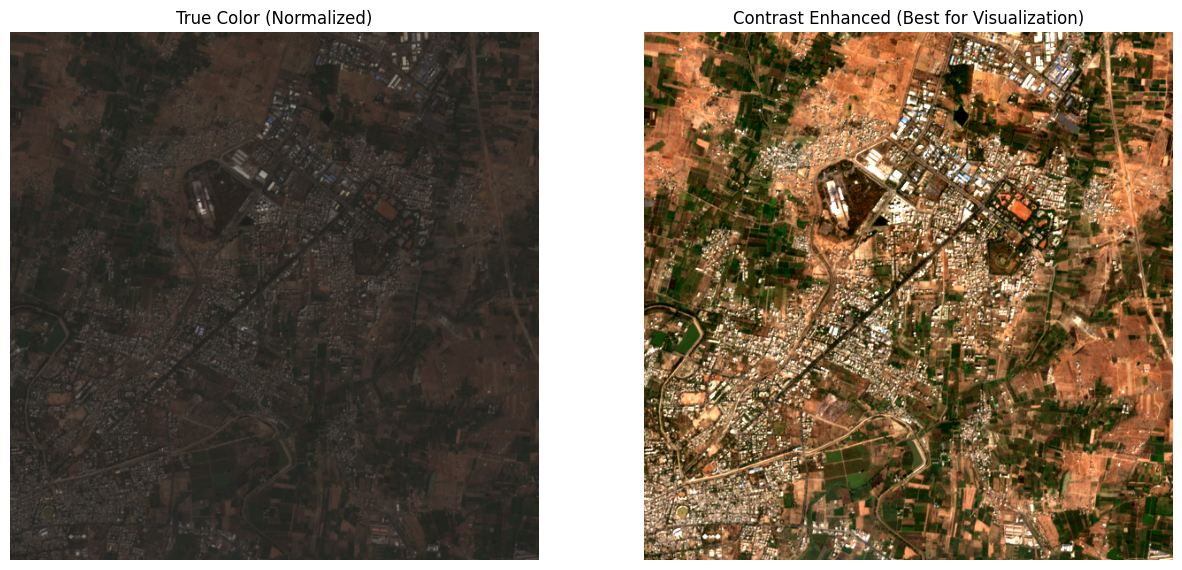

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# ============================
# CONFIGURATION
# ============================
FILE_PATH = './export/sentinel_export.tif'

def normalize(array):
    """
    Normalizes a numpy array to 0-1 range for display.
    Handles 16-bit (0-10000) and 8-bit (0-255) data automatically.
    """
    array = array.astype(float)
    
    # Check if image is likely 16-bit raw data (values > 255)
    if array.max() > 255:
        print("Detected 16-bit data. Scaling down...")
        array = array / 10000.0  # Sentinel-2 reflectance scale
    elif array.max() > 1.0:
        print("Detected 8-bit data. Scaling to 0-1...")
        array = array / 255.0
        
    # Clip to valid range [0, 1] to avoid errors
    return np.clip(array, 0, 1)

def contrast_stretch(data, percent=2):
    """
    Applies a percentile stretch to make the image look better 
    (removes the darkest and brightest 2% of pixels).
    """
    p2, p98 = np.percentile(data, (percent, 100 - percent))
    return np.interp(data, (p2, p98), (0, 1))

# ============================
# MAIN VISUALIZATION
# ============================
try:
    with rasterio.open(FILE_PATH) as src:
        print(f"Opened: {FILE_PATH}")
        print(f"Size: {src.width}x{src.height}, Bands: {src.count}")
        
        # Read the first 3 bands (Assumes RGB are bands 1, 2, 3)
        # If your image looks blue, try changing this to [3, 2, 1]
        img = src.read([1, 2, 3])
        
        # Move bands to the last dimension: (3, H, W) -> (H, W, 3)
        img = np.moveaxis(img, 0, -1)
        
        # 1. Basic Normalization
        img_norm = normalize(img)
        
        # 2. Contrast Stretching (Makes it look good to human eye)
        img_stretched = contrast_stretch(img_norm)

        # Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

        # Plot 1: True Color (Natural)
        ax1.imshow(img_norm)
        ax1.set_title("True Color (Normalized)")
        ax1.axis('off')

        # Plot 2: Contrast Stretched (Enhanced)
        ax2.imshow(img_stretched)
        ax2.set_title("Contrast Enhanced (Best for Visualization)")
        ax2.axis('off')

        plt.show()

except FileNotFoundError:
    print(f"Error: The file '{FILE_PATH}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")